In [1]:
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np 
#import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import sys

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx
from tqdm import tqdm

sys.path.append('..')

from CD_methods import SCM_learner, observational_learner, interventional_learner
from functions import *

In [16]:
network_data = torch.load('../data/c_elegans_data.pt')

with open('../data/c_elegans_spike_data_single_node_stimuli.pickle', 'rb') as f:
    spike_data = pickle.load(f)

### Subsample the graph

- Determine what neurons have opsin
- Neuron will express opsin with some probability
- Light stimulation will not be perfectly local, so stimulation mask should be diffuse wrt neuron position
- Need to compute radius of stimulus as a function of the intensity

In [17]:
G = to_networkx(network_data, node_attrs = ['position'])
position_dict = nx.get_node_attributes(G, 'position')
ap_axis = []
xy_position_dict = dict()
for node in position_dict:
    y = np.random.random()
    x = position_dict[node]
    xy_position_dict[node] = np.array([x, y])

In [18]:
n_neurons = G.number_of_nodes()

In [19]:
sample_space = []
upper = 0.25 # head
lower = 0.
for neuron in position_dict:
    if position_dict[neuron] > lower and position_dict[neuron] < upper:
        sample_space.append(neuron)

print('Size of sample space = ',len(sample_space))
n_obs = 30
index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))

prob_activated = 1 / 2
opsin = np.random.random(n_neurons)

stimulus_masks = opsin < prob_activated
index_opsin = np.where(stimulus_masks)[0]

Size of sample space =  165


In [20]:
G_true = nx.subgraph(G, index_obs)
color_map = ['tomato' if node in index_opsin else 'cornflowerblue' for node in G_true]

<Figure size 2500x500 with 0 Axes>

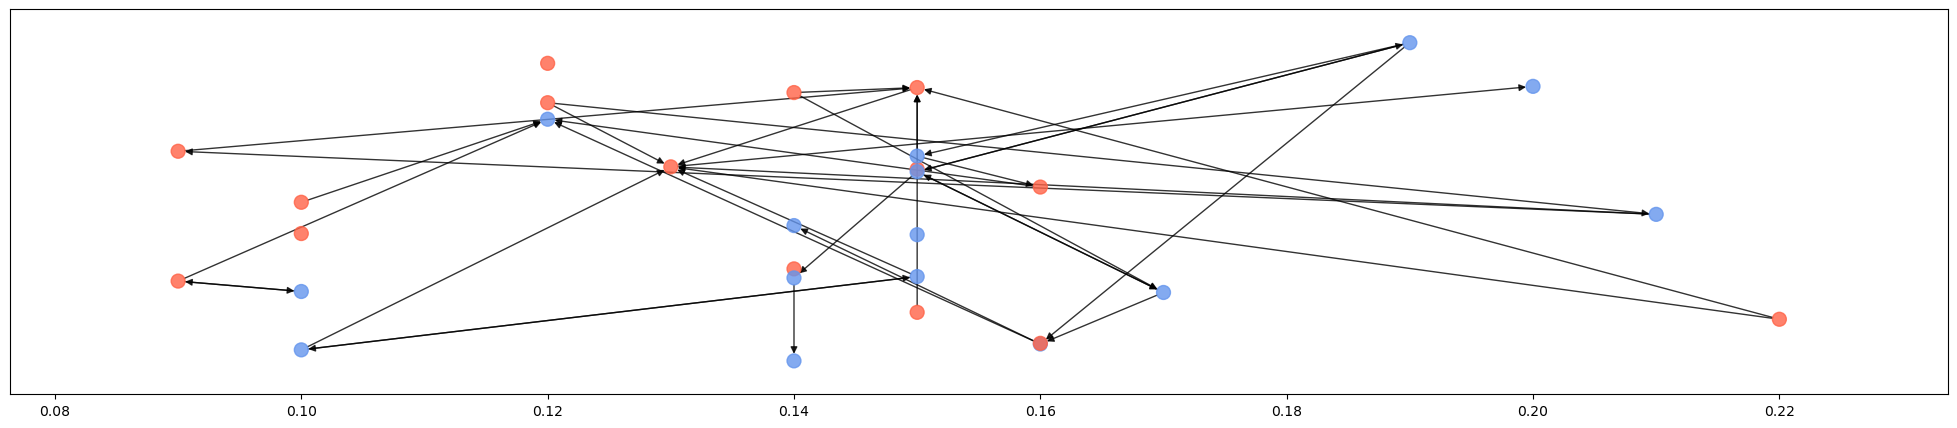

In [21]:
plt.figure(figsize=(25,5))
fig, ax = plt.subplots(figsize=(25,5))

nx.draw_networkx(G_true, 
                 pos=xy_position_dict, 
                 arrows=True, 
                 with_labels=False, 
                 arrowsize=10, 
                 node_size=100, 
                 alpha=0.8, 
                 node_color=color_map,
                 ax=ax)
ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
plt.show()

In [288]:
G_observational = observational_learner(
    spike_data['null'][index_obs], 
    node_list=index_obs, 
    alpha = 0.01)

In [289]:
SHD_null = compute_SHD(G_true=G_true, G_learned=G_observational)
print('SHD =',SHD_null, '\nSHD / num. edges =', np.round(SHD_null / G_true.number_of_edges(), 3))
#print('SHD =',SHD_null, '\nnum. edges obs / num. edges =', np.round(G_observational.number_of_edges() / G_true.number_of_edges(), 3))

SHD = 42 
SHD / num. edges = 0.362


### Note:
- can try to compute the avg. proportion of false edges depending on num. observed nodes

In [290]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=1,
    abs_ref_scale=3,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [294]:
optogenetic_stimulation_dict = dict()
for prob_activated in [0.1, 0.2, 0.5, 0.7, 0.8, 0.9]:
    G_learned = G_observational.copy()
    optogenetic_stimulation_dict[prob_activated] = dict()
    optogenetic_stimulation_dict[prob_activated]['SHD'] = [SHD_null]
    optogenetic_stimulation_dict[prob_activated]['sensitivity'] = [compute_sensitivity(G_learned=G_learned, 
                                                                                       G_true=G_true, 
                                                                                       nodelist=index_obs)]
    optogenetic_stimulation_dict[prob_activated]['specificity'] = [compute_specificity(G_learned=G_learned, 
                                                                                       G_true=G_true, 
                                                                                       nodelist=index_obs)]

    #print(prob_activated)
    for _ in tqdm(range(15)):    
        spike_data_obs = dict()

        # optogenetic stimulation
        stimulus_mask = torch.rand(n_neurons) < prob_activated
        index_opsin = [node for node in G_true if node in np.where(stimulus_mask)[0]]
        intervention_str = '_'.join(str(x) for x in index_opsin) 

        neuron_model.add_stimulus(lambda t: 2*stimulus_mask) # all nodes with opsin are stimulated
        #neuron_model.add_stimulus(lambda t: 2*(t % 1000 < 200)*stimulus_mask) # all nodes with opsin are stimulated

        spikes = neuron_model.simulate(network_data, n_steps=10**4, verbose=False)    
        spike_data_obs[intervention_str] = spikes[index_obs]    

        # learn graph from interventional data
        G_learned = interventional_learner(
            spike_data_obs,
            node_list=index_obs, 
            stimulation_protocol=[index_opsin], # list of nodes with opsin 
            SCM_learned=G_learned,
            alpha = 1e-5,
            verbose=False)
        
        SHD_learned = compute_SHD(G_true=G_true, G_learned=G_learned)
        optogenetic_stimulation_dict[prob_activated]['SHD'].append(SHD_learned)
        optogenetic_stimulation_dict[prob_activated]['sensitivity'].append(compute_sensitivity(G_learned=G_learned, 
                                                                                       G_true=G_true, 
                                                                                       nodelist=index_obs))
        optogenetic_stimulation_dict[prob_activated]['specificity'].append(compute_specificity(G_learned=G_learned, 
                                                                               G_true=G_true, 
                                                                               nodelist=index_obs))

100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.00s/it]


p = 0.3, num experiments: 10
p = 0.4, num experiments: need more experiments
p = 0.6, num experiments: need more experiments
p = 0.1, num experiments: need more experiments
p = 0.2, num experiments: need more experiments
p = 0.5, num experiments: need more experiments
p = 0.7, num experiments: need more experiments
p = 0.8, num experiments: need more experiments
p = 0.9, num experiments: need more experiments


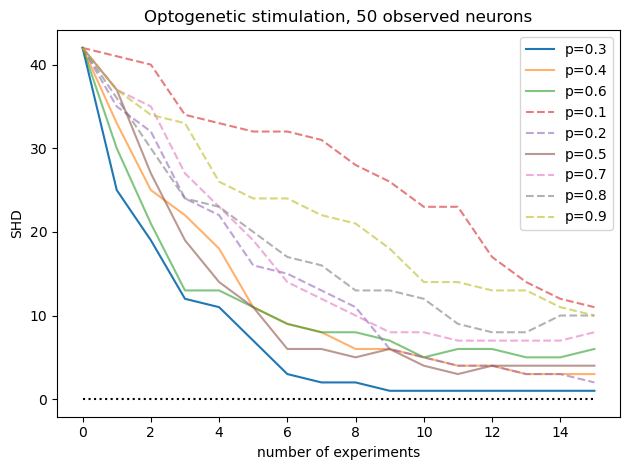

In [298]:
for prob in optogenetic_stimulation_dict:
    if prob == 0.3:
        alpha = 1
    else:
        alpha = 0.6
    if prob in [0.3, 0.4, 0.5, 0.6]:
        plt.plot(optogenetic_stimulation_dict[prob]['SHD'], label=f'p={np.round(prob, 1)}', alpha=alpha)
    else:
        plt.plot(optogenetic_stimulation_dict[prob]['SHD'], label=f'p={np.round(prob, 1)}', linestyle='dashed', alpha=alpha)
    shd = optogenetic_stimulation_dict[prob]['SHD']
    print(f'p = {np.round(prob, 1)}, num experiments:', shd.index(1)+1 if 1 in shd else 'need more experiments')
plt.title(f'Optogenetic stimulation, {n_obs} observed neurons')
plt.hlines(y=0, xmin=0, xmax=15, linestyles='dotted', color='black')
plt.legend()
plt.xlabel('number of experiments')
plt.ylabel('SHD')
plt.tight_layout()
plt.show()

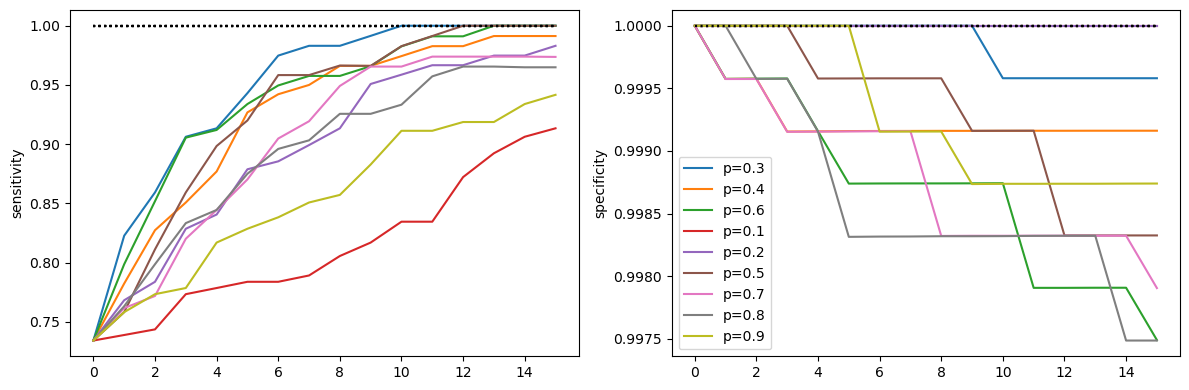

In [299]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for prob in optogenetic_stimulation_dict:
    ax[0].plot(optogenetic_stimulation_dict[prob]['sensitivity'], label=f'p={np.round(prob, 4)}')
    ax[1].plot(optogenetic_stimulation_dict[prob]['specificity'], label=f'p={np.round(prob, 4)}')
    ax[0].hlines(y=1, xmin=0, xmax=15, linestyles='dotted', color='black')
    ax[1].hlines(y=1, xmin=0, xmax=15, linestyles='dotted', color='black')

#plt.title(f'Optogenetic stimulation, {n_obs} observed neurons')
plt.legend()
#fig.xlabel('number of experiments')
ax[0].set_ylabel('sensitivity')
ax[1].set_ylabel('specificity')
plt.tight_layout()
plt.show()

## notes
- 0.3-0.6 prob og expressing gene seems to work quite well
- how can the learned graph be validated?
- Seems that pulse stimulation is better than constant stimulation
- Taylor exp av den generative modellen, kan kanskje argumentere for at man har en approximativ lineær fyringsrate
- se fig 18.11 i Koch
- diskutere antagelser og feilkilder som kan oppstå når man antar lineæritet
- 

In [161]:
nodes_by_out_degree = [node for node, _ in sorted(G_observational.out_degree, key=lambda x: x[1], reverse=True)]

In [163]:
print(nodes_by_out_degree)

[137, 99, 129, 208, 255, 15, 55, 145, 276, 65, 103, 125, 135, 168, 175, 226, 239, 12, 26, 87, 89, 144, 176, 225, 33, 63, 105, 170, 233, 245, 252, 254, 59, 113, 115, 127, 161, 165, 227, 249, 273, 31, 50, 53, 64, 117, 133, 160, 207, 209]


In [301]:
import random

In [302]:
eps = 0.025
intervention_sets = []
for target_position in np.arange(0, 0.3, eps):
    intervention_set = [x for x in index_obs if np.abs(position_dict[x] - target_position) <= eps]
    #print(np.round(target_position, 4))
    if intervention_set and intervention_set not in intervention_sets:
        intervention_sets.append(intervention_set)

In [317]:
#intervention_sets
SHD_light_dict = dict()

In [324]:
G_learned = G_observational.copy()
SHD_list[eps] = [SHD_null]
random.shuffle(intervention_sets)
for prob_activated in [.05]:
    SHD_light_dict[prob_activated] = [SHD_null]
    
    for intervention in intervention_sets:    
        spike_data_obs = dict()

        # do stimulation
        light = torch.zeros(n_neurons, dtype=torch.bool)
        light[intervention] = True
        opsin = torch.rand(n_neurons) < prob_activated

        stimulus_mask = opsin * light
        #print(stimulus_mask.sum())
        intervention_str = '_'.join(str(x) for x in intervention) 

        #neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
        neuron_model.add_stimulus(lambda t: 2*(t % 1000 < 200)*stimulus_mask) # all nodes with opsin are stimulated

        spikes = neuron_model.simulate(network_data, n_steps=10**4, verbose=False)    
        spike_data_obs[intervention_str] = spikes[index_obs]    

        G_learned = interventional_learner(
            spike_data_obs,
            node_list=index_obs, 
            stimulation_protocol=[intervention],
            SCM_learned=G_learned,
            alpha = 1e-5,
            verbose=False)

        SHD_light_dict[prob_activated].append(compute_SHD(G_learned=G_learned, G_true=G_true))

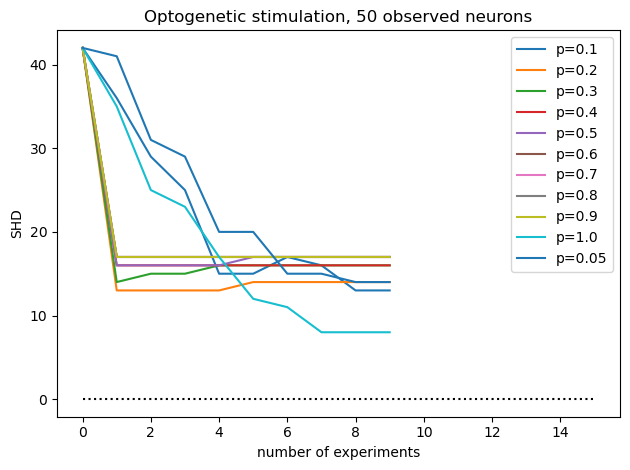

In [325]:
for prob_activated in SHD_light_dict:
    plt.plot(SHD_light_dict[prob_activated], label = f'p={prob_activated}')
plt.title(f'Optogenetic stimulation, {n_obs} observed neurons')
plt.hlines(y=0, xmin=0, xmax=15, linestyles='dotted', color='black')
plt.legend()
plt.xlabel('number of experiments')
plt.ylabel('SHD')
plt.tight_layout()
plt.show()

In [312]:
prob_activated

0.9